In [308]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer
from sklearn.feature_selection import SelectKBest, f_regression
import warnings
from sklearn.preprocessing import OneHotEncoder
from category_encoders.target_encoder import TargetEncoder
warnings.filterwarnings('ignore')
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer


In [309]:
# Configuración de visualización
sns.set_theme(style="darkgrid", palette="husl")
sns.set_palette("husl")

In [310]:
# Cargar el archivo 
try:
    df = pd.read_csv("./data/train.csv", encoding='utf-8')
    print("Archivo cargado correctamente.")
except FileNotFoundError:
    print("No se encontró el archivo. Verifica la ruta.")
    raise

Archivo cargado correctamente.


In [311]:
# Cargar test.csv
df_test = pd.read_csv("data/test.csv")

# Normalizar nombres de columnas
df_test.columns = df_test.columns.str.lower()

# Guardar la columna ID para después
id_column = df_test["id"]


In [312]:
# Revisión de valores nulos
print("Valores nulos por columna:")
print(df.isna().sum().sort_values(ascending=False))

Valores nulos por columna:
FAMI_TIENEAUTOMOVIL               43623
FAMI_TIENELAVADORA                39773
FAMI_TIENECOMPUTADOR              38103
FAMI_ESTRATOVIVIENDA              32137
ESTU_HORASSEMANATRABAJA           30857
FAMI_TIENEINTERNET                26629
FAMI_TIENEINTERNET.1              26629
FAMI_EDUCACIONMADRE               23664
FAMI_EDUCACIONPADRE               23178
ESTU_PAGOMATRICULAPROPIO           6498
ESTU_VALORMATRICULAUNIVERSIDAD     6287
coef_3                                0
coef_2                                0
coef_1                                0
RENDIMIENTO_GLOBAL                    0
ID                                    0
ESTU_PRIVADO_LIBERTAD                 0
PERIODO                               0
ESTU_PRGM_DEPARTAMENTO                0
ESTU_PRGM_ACADEMICO                   0
coef_4                                0
dtype: int64



Porcentaje de valores nulos por columna:
FAMI_TIENEAUTOMOVIL               6.299350
FAMI_TIENELAVADORA                5.743394
FAMI_TIENECOMPUTADOR              5.502238
FAMI_ESTRATOVIVIENDA              4.640722
ESTU_HORASSEMANATRABAJA           4.455884
FAMI_TIENEINTERNET                3.845343
FAMI_TIENEINTERNET.1              3.845343
FAMI_EDUCACIONMADRE               3.417184
FAMI_EDUCACIONPADRE               3.347004
ESTU_PAGOMATRICULAPROPIO          0.938339
ESTU_VALORMATRICULAUNIVERSIDAD    0.907870
coef_3                            0.000000
coef_2                            0.000000
coef_1                            0.000000
RENDIMIENTO_GLOBAL                0.000000
ID                                0.000000
ESTU_PRIVADO_LIBERTAD             0.000000
PERIODO                           0.000000
ESTU_PRGM_DEPARTAMENTO            0.000000
ESTU_PRGM_ACADEMICO               0.000000
coef_4                            0.000000
dtype: float64


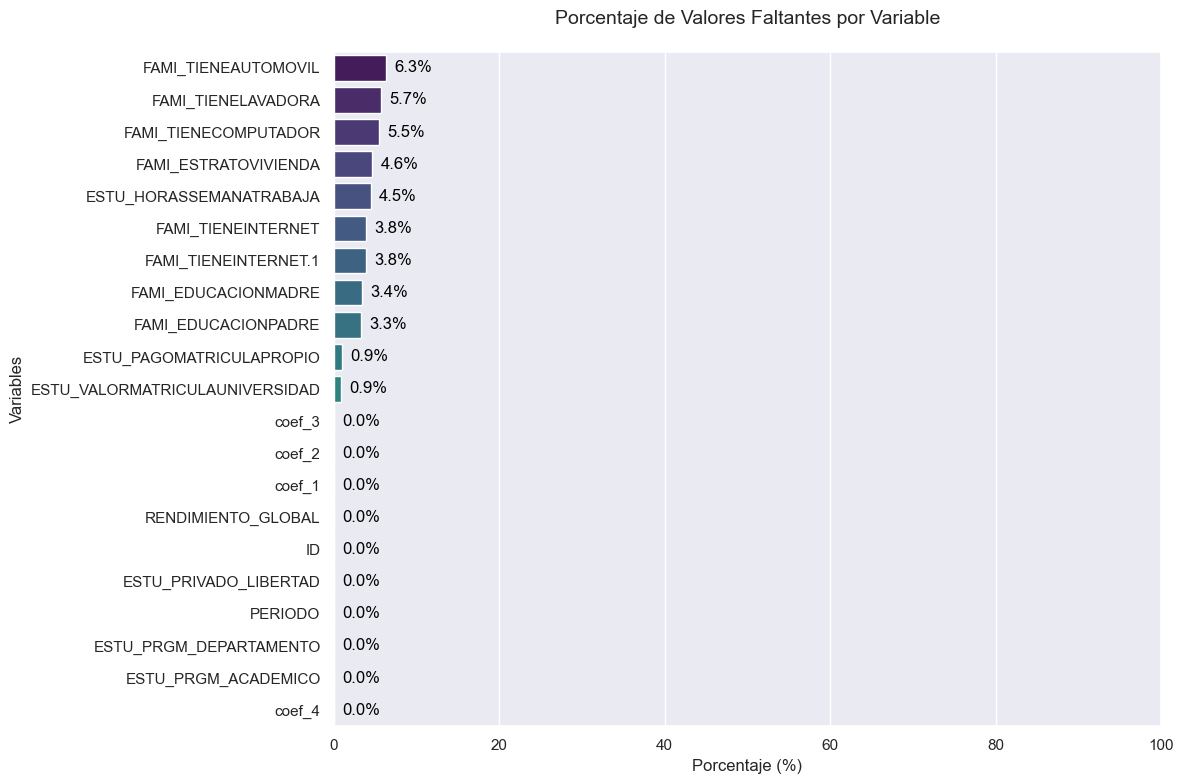

In [313]:
# Análisis de valores nulos
print("\nPorcentaje de valores nulos por columna:")
missing_pct = (df.isnull().sum() / len(df) * 100).sort_values(ascending=False)
print(missing_pct)  # Mostrar los porcentajes en la consola

# Visualización
plt.figure(figsize=(12, 8))
ax = sns.barplot(x=missing_pct.values, y=missing_pct.index, palette="viridis")

# Mejoras en la visualización
plt.title('Porcentaje de Valores Faltantes por Variable', fontsize=14, pad=20)
plt.xlabel('Porcentaje (%)', fontsize=12)
plt.ylabel('Variables', fontsize=12)
plt.xlim(0, 100)  # Establecer límite máximo del 100%

# Agregar etiquetas de valor
for i, v in enumerate(missing_pct.values):
    ax.text(v + 1, i, f"{v:.1f}%", color='black', va='center')

plt.tight_layout()  # Ajustar layout para evitar cortes
plt.show()

In [314]:
# Eliminar columnas con más del 50% de valores nulos
threshold = 0.5
missing = df.isna().mean()
cols_to_drop = missing[missing > threshold].index
print(f"Columnas eliminadas por exceso de nulos: {cols_to_drop.tolist()}")
df.drop(columns=cols_to_drop, inplace=True)


Columnas eliminadas por exceso de nulos: []


In [315]:
# Transformación de variables numéricas para train y test
rangos_valores = {
    'estu_valormatriculauniversidad_menos de 500 mil': 0.25,
    'estu_valormatriculauniversidad_entre 500 mil y menos de 1 millón': 0.75,
    'estu_valormatriculauniversidad_entre 1 millón y menos de 2.5 millones': 1.75,
    'estu_valormatriculauniversidad_entre 2.5 millones y menos de 4 millones': 3.25,
    'estu_valormatriculauniversidad_entre 4 millones y menos de 5.5 millones': 4.75,
    'estu_valormatriculauniversidad_entre 5.5 millones y menos de 7 millones': 6.25,
    'estu_valormatriculauniversidad_más de 7 millones': 8.00,
    'estu_valormatriculauniversidad_no pagó matrícula': 0.00
}

def calcular_valormatricula_numerico(df_):
    return sum(
        df_[col] * val for col, val in rangos_valores.items() if col in df_.columns
    )

df['valormatricula_numerico'] = calcular_valormatricula_numerico(df)
df_test['valormatricula_numerico'] = calcular_valormatricula_numerico(df_test)


In [316]:
# Separar variables predictoras y objetivo
X = df.drop("RENDIMIENTO_GLOBAL", axis=1)
y = df["RENDIMIENTO_GLOBAL"]

# Dividir en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [317]:
# Crear pipelines de preprocesamiento
numeric_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

# Combinar en un preprocesador
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_pipeline, num_cols),
    ('cat', categorical_pipeline, cat_cols)
])


In [318]:
# Dividir en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [319]:
# Normalización avanzada
scaler = StandardScaler()
num_cols = df.select_dtypes(include=np.number).columns
# Corregir columnas numéricas: eliminar 'ID' y 'PERIODO' si están
num_cols = [col for col in num_cols if col not in ['ID', 'PERIODO']]
df[num_cols] = scaler.fit_transform(df[num_cols])


In [320]:
# 1. Definir columnas numéricas usadas en el entrenamiento (las que usó el scaler)
original_num_cols = scaler.feature_names_in_.tolist()

# 2. Agregar columnas faltantes en df_test con 0
for col in original_num_cols:
    if col not in df_test.columns:
        df_test[col] = 0

# 3. Reordenar columnas para que coincidan exactamente
df_test = df_test.reindex(columns=sorted(df_test.columns))  # opcional
cols_to_scale_test = [col for col in original_num_cols if col in df_test.columns]
df_test = df_test.reindex(columns=original_num_cols)

# 4. Escalar
df_test[original_num_cols] = scaler.transform(df_test[original_num_cols])


In [321]:
# Verificar que la columna 'RENDIMIENTO_GLOBAL' exista y crear la columna binaria
if 'rendimiento_global_medio-alto' not in df.columns and 'RENDIMIENTO_GLOBAL' in df.columns:
    df['rendimiento_global_medio-alto'] = (df['RENDIMIENTO_GLOBAL'] == 'medio-alto').astype(int)


In [322]:
target = 'rendimiento_global_medio-alto'
y = df[target]


In [323]:
num_cols = X_train.select_dtypes(include=["int64", "float64"]).columns.tolist()
cat_cols = X_train.select_dtypes(include=["object", "category"]).columns.tolist()


In [324]:
# Ajustar el preprocesador a los datos
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_pipeline, num_cols),
    ('cat', categorical_pipeline, cat_cols)
])
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_pipeline, num_cols),
    ('cat', categorical_pipeline, cat_cols)
])



In [325]:
# Estrategias de imputación
class AdvancedImputer:
    def __init__(self):
        self.num_imputer = IterativeImputer(random_state=42)
        self.cat_imputer = SimpleImputer(strategy='most_frequent')
        
    def fit_transform(self, df):
        # Numéricas
        num_cols = df.select_dtypes(include=np.number).columns
        df[num_cols] = self.num_imputer.fit_transform(df[num_cols])
        
        # Categóricas
        cat_cols = df.select_dtypes(include=['object']).columns
        if len(cat_cols) > 0:
            df[cat_cols] = self.cat_imputer.fit_transform(df[cat_cols])
        
        return df


imputer = AdvancedImputer()
df = imputer.fit_transform(df)

In [326]:
# Verificar si quedan valores nulos en el DataFrame
nulos_totales = df.isnull().sum().sum()

if nulos_totales == 0:
    print("No hay valores nulos en el DataFrame después de la imputación.")
else:
    print(f"Quedan {nulos_totales} valores nulos en el DataFrame.")
    print(df.isnull().sum()[df.isnull().sum() > 0])


No hay valores nulos en el DataFrame después de la imputación.


In [327]:

def codificacion_avanzada(df, target_col=None, umbral=10):
    """
    Aplica codificación avanzada a variables categóricas:
    - Target Encoding para características con alta cardinalidad
    - One-Hot Encoding para características con baja cardinalidad

    Parámetros:
    df: DataFrame a codificar
    target_col: nombre de la columna objetivo para usar en Target Encoding
    umbral: Límite de cardinalidad para decidir entre target y one-hot encoding (por defecto=10)

    Retorna:
    DataFrame con variables categóricas codificadas.
    """
    if target_col is None or target_col not in df.columns:
        raise ValueError("Debes especificar una columna 'target_col' válida para aplicar Target Encoding.")

    # 1. Identificar columnas categóricas
    columnas_categoricas = df.select_dtypes(include=['object', 'category']).columns

    # 2. Separar características por cardinalidad
    columnas_alta_card = [col for col in columnas_categoricas if df[col].nunique() > umbral]
    columnas_baja_card = [col for col in columnas_categoricas if col not in columnas_alta_card]

    # 3. One-Hot Encoding para baja cardinalidad
    if columnas_baja_card:
        codificador_oh = OneHotEncoder(drop='first', sparse_output=False)
        matriz_oh = codificador_oh.fit_transform(df[columnas_baja_card])
        columnas_oh = codificador_oh.get_feature_names_out(columnas_baja_card)
        df_oh = pd.DataFrame(matriz_oh, columns=columnas_oh, index=df.index)
    else:
        df_oh = pd.DataFrame(index=df.index)

    # 4. Target Encoding para alta cardinalidad
    if columnas_alta_card:
        codificador_target = TargetEncoder(cols=columnas_alta_card)
        df_target = codificador_target.fit_transform(df[columnas_alta_card], df[target_col])
    else:
        df_target = pd.DataFrame(index=df.index)

    # 5. Eliminar columnas categóricas originales y unir todo
    df_sin_cat = df.drop(columns=columnas_categoricas)
    df_codificado = pd.concat([df_sin_cat, df_oh, df_target], axis=1)

    return df_codificado


In [328]:
# Separar columnas numéricas y categóricas, excluyendo 'id'
num_cols = X.select_dtypes(include=["int64", "float64"]).columns.drop('ID')
cat_cols = X.select_dtypes(include=["object", "category"]).columns


In [329]:
# Tomar intersección común de columnas entre train y test
common_cols = X.columns.intersection(df_test.columns)
# Reducir ambos conjuntos a esas columnas
X_common = X[common_cols]
df_test_common = df_test[common_cols]


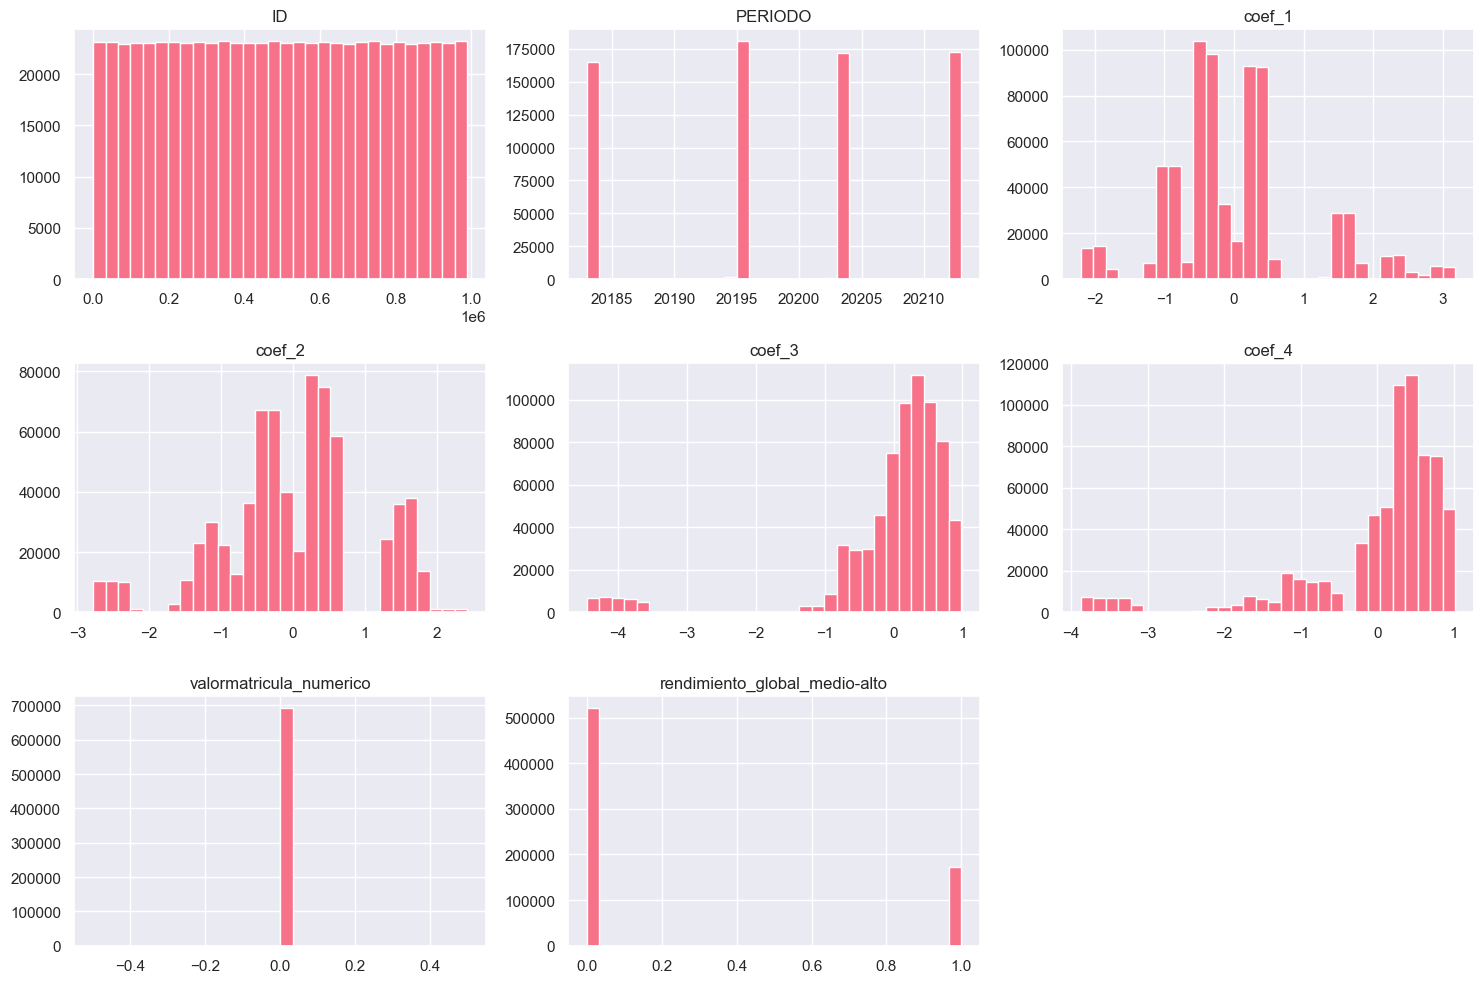

In [330]:
# Histograma de variables numéricas
df.hist(figsize=(15, 10), bins=30)
plt.tight_layout()
plt.show()


In [331]:
# 1. Crear variable target binaria
df['rendimiento_global_medio-alto'] = (df['RENDIMIENTO_GLOBAL'] == 'medio-alto').astype(int)


# 2. Aplicar codificación avanzada antes de definir features
df = codificacion_avanzada(df, target_col='rendimiento_global_medio-alto')

# 3. Eliminar duplicados de columnas (por seguridad)
df = df.loc[:, ~df.columns.duplicated()]

# 4. Definir target y features
target = 'rendimiento_global_medio-alto'
features = [col for col in df.columns if col != target]

# 5. Validar existencia del target
if target not in df.columns:
    raise ValueError(f"La columna target '{target}' no existe en el DataFrame")

# 6. Separar variables predictoras (X) y variable objetivo (y)
X = df[features]
y = df[target]

# 7. Verificar que X no contenga columnas no numéricas
if X.select_dtypes(include='object').shape[1] > 0:
    raise ValueError("Aún hay columnas categóricas sin codificar en X")

# 8. Selección de variables numéricas más importantes
k = min(15, X.shape[1])  # Máximo 15 o menos si no hay tantas variables
selector = SelectKBest(score_func=f_regression, k=k)
X_selected = selector.fit_transform(X, y)

# 9. Obtener nombres de las variables seleccionadas
selected_features = X.columns[selector.get_support()].tolist()
print("\nCaracterísticas seleccionadas:")
print(selected_features)


Características seleccionadas:
['ESTU_VALORMATRICULAUNIVERSIDAD_Entre 4 millones y menos de 5.5 millones', 'ESTU_VALORMATRICULAUNIVERSIDAD_Más de 7 millones', 'ESTU_HORASSEMANATRABAJA_Menos de 10 horas', 'ESTU_HORASSEMANATRABAJA_Más de 30 horas', 'FAMI_ESTRATOVIVIENDA_Estrato 3', 'FAMI_TIENEINTERNET_Si', 'FAMI_TIENECOMPUTADOR_Si', 'FAMI_TIENEINTERNET.1_Si', 'RENDIMIENTO_GLOBAL_bajo', 'RENDIMIENTO_GLOBAL_medio-alto', 'RENDIMIENTO_GLOBAL_medio-bajo', 'ESTU_PRGM_ACADEMICO', 'ESTU_PRGM_DEPARTAMENTO', 'FAMI_EDUCACIONPADRE', 'FAMI_EDUCACIONMADRE']


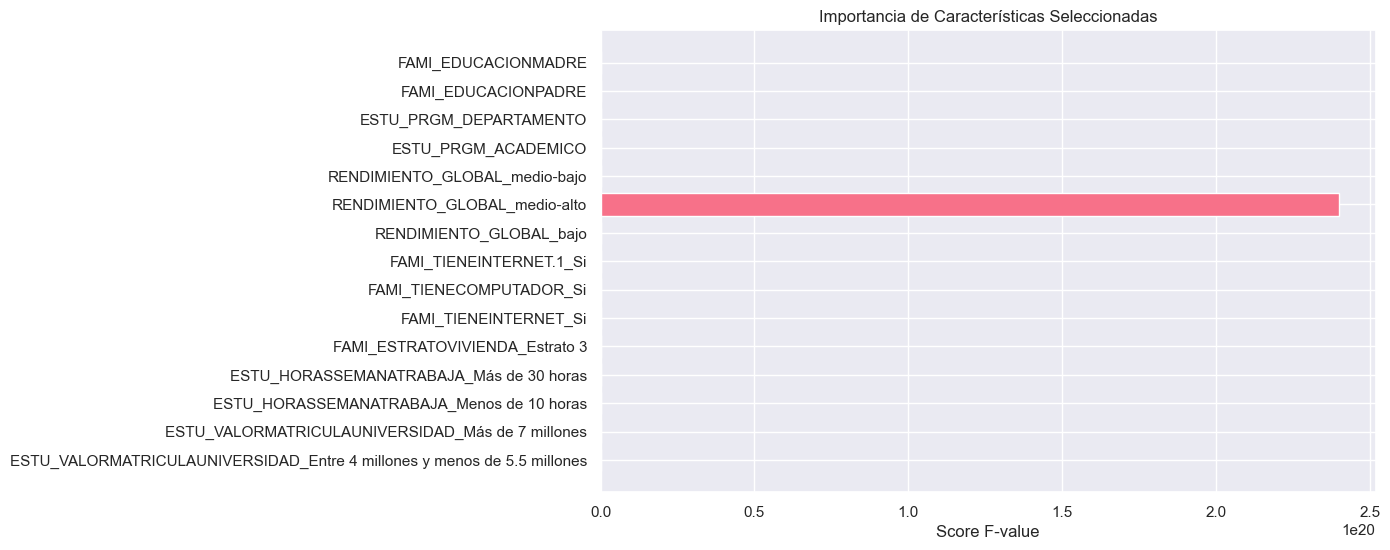


DataFrame con características seleccionadas:
   ESTU_VALORMATRICULAUNIVERSIDAD_Entre 4 millones y menos de 5.5 millones  \
0                                                0.0                         
1                                                0.0                         
2                                                0.0                         
3                                                1.0                         
4                                                0.0                         

   ESTU_VALORMATRICULAUNIVERSIDAD_Más de 7 millones  \
0                                               0.0   
1                                               0.0   
2                                               0.0   
3                                               0.0   
4                                               0.0   

   ESTU_HORASSEMANATRABAJA_Menos de 10 horas  \
0                                        1.0   
1                                        0.0   
2         

In [332]:
# Analizar importancia de características
scores = selector.scores_[selector.get_support()]
plt.figure(figsize=(10, 6))
plt.barh(selected_features, scores)
plt.title('Importancia de Características Seleccionadas')
plt.xlabel('Score F-value')
plt.show()

# Crear nuevo DataFrame con características seleccionadas
df_selected = pd.DataFrame(X_selected, columns=selected_features)
df_selected[target] = y

print("\nDataFrame con características seleccionadas:")
print(df_selected.head())

# Ver distribución de la variable target
print("\nDistribución de la variable target:")
print(df_selected[target].value_counts(normalize=True))

In [333]:
# División de datos
X_train, X_test, y_train, y_test = train_test_split(
    X[selected_features], y, test_size=0.2, random_state=42)

print("\nDistribución de conjuntos:")
print(f"Entrenamiento: {X_train.shape[0]} muestras")
print(f"Prueba: {X_test.shape[0]} muestras")



Distribución de conjuntos:
Entrenamiento: 554000 muestras
Prueba: 138500 muestras


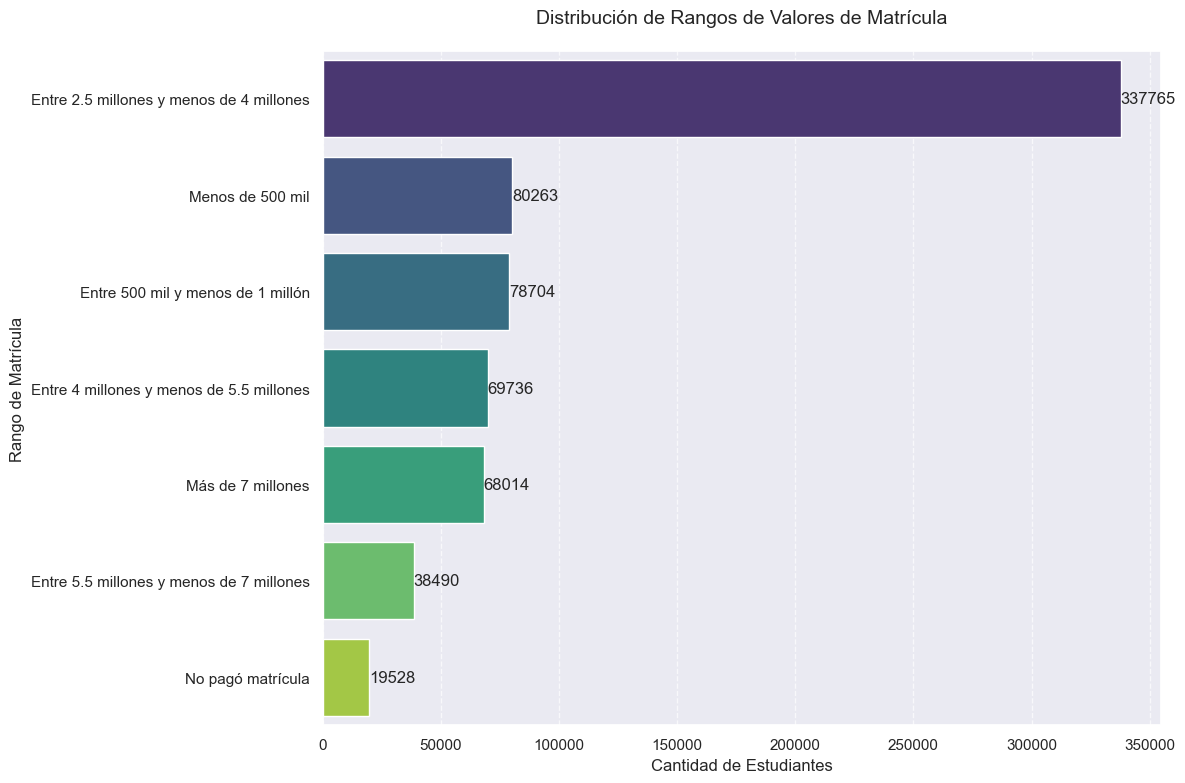

In [334]:
# 1. Verificación y preparación segura de datos
try:
    # Identificar columnas de matrícula
    matricula_cols = [col for col in df.columns if col.startswith('ESTU_VALORMATRICULAUNIVERSIDAD_')]
    
    if not matricula_cols:
        raise ValueError("No se encontraron columnas de matrícula universitaria")
    
    # Reconstrucción segura de la columna categórica
    if not df[matricula_cols].empty:
        # Crear columna con el nombre de la categoría seleccionada
        df['ESTU_VALORMATRICULAUNIVERSIDAD'] = (
            df[matricula_cols]
            .idxmax(axis=1)
            .str.replace('ESTU_VALORMATRICULAUNIVERSIDAD_', '', regex=False)
        )
    else:
        df['ESTU_VALORMATRICULAUNIVERSIDAD'] = 'SIN_DATOS'
    
    # 2. Conteo y ordenamiento de categorías
    counts = df['ESTU_VALORMATRICULAUNIVERSIDAD'].value_counts()
    
    # 3. Visualización mejorada
    plt.figure(figsize=(12, 8))
    ax = sns.countplot(
        data=df,
        y='ESTU_VALORMATRICULAUNIVERSIDAD',
        order=counts.index,
        palette='viridis'
    )
    
    # Añadir etiquetas de valor
    for p in ax.patches:
        width = p.get_width()
        ax.text(width + 5, p.get_y() + p.get_height()/2.,
                f'{int(width)}',
                ha='left', va='center')
    
    plt.title('Distribución de Rangos de Valores de Matrícula', fontsize=14, pad=20)
    plt.xlabel('Cantidad de Estudiantes', fontsize=12)
    plt.ylabel('Rango de Matrícula', fontsize=12)
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

except Exception as e:
    print(f"Error al generar el gráfico: {str(e)}")
    # Gráfico alternativo si hay problemas
    if 'ESTU_VALORMATRICULAUNIVERSIDAD' in df.columns:
        plt.figure(figsize=(10,6))
        df['ESTU_VALORMATRICULAUNIVERSIDAD'].value_counts().plot(kind='barh')
        plt.title('Distribución de Matrículas (visualización alternativa)')
        plt.show()


In [335]:
#Guardar el DataFrame procesado
df.to_csv("./data/train_preprocesado.csv", index=False)
print("Archivo preprocesado guardado correctamente.")


Archivo preprocesado guardado correctamente.


In [336]:
# --- PREPROCESAMIENTO DEL TEST PARA ALINEARLO CON EL TRAIN ---

# 1. Imputar valores faltantes en df_test usando el mismo imputador
df_test = imputer.fit_transform(df_test)

# 2. Escalar las columnas numéricas originales (sin ID ni PERIODO)
# Asegúrate de haber definido esto ANTES al entrenar tu modelo:
# original_num_cols = [col for col in df.columns if df[col].dtype in [int, float] and col not in ['ID', 'PERIODO']]
cols_to_scale_test = [col for col in original_num_cols if col in df_test.columns]
df_test[cols_to_scale_test] = scaler.transform(df_test[cols_to_scale_test])

# 3. Agregar columna dummy para target (necesaria para codificación)
df_test['rendimiento_global_medio-alto'] = 0

# 4. Aplicar codificación avanzada (igual que a train)
df_test = codificacion_avanzada(df_test, target_col='rendimiento_global_medio-alto')

# 5. Eliminar columnas duplicadas (por seguridad)
df_test = df_test.loc[:, ~df_test.columns.duplicated()]

# 6. Asegurar que tenga las mismas columnas que train (sin target)
missing_cols = [col for col in X.columns if col not in df_test.columns]
for col in missing_cols:
    df_test[col] = 0  # agrega columna faltante con ceros

# 7. Alinear el orden de las columnas exactamente como X
df_test = df_test[X.columns]

# 8. Guardar el conjunto preprocesado
df_test.to_csv('test_preprocesado.csv', index=False)
print("✅ test_preprocesado.csv guardado correctamente.")



✅ test_preprocesado.csv guardado correctamente.
